#  Algoritmo de colonia de hormigas para el problema del viajante de comercio

### Descripción

<font size="4"> Algoritmo de colonia de hormigas para el problema del viajante de comercio. Se usa como coste la distancia entre las ciudades calculada a partir de las coordenadas geográficas.
    
<font size="4"> Implementación realizada a partir del artículo original de los autores (versión ant-cicle):

<font size="4"> Colorni, Alberto \& Dorigo, Marco \& Maniezzo, Vittorio. (1991). Distributed Optimization by Ant Colonies. Proceedings of the First European Conference on Artificial Life. 
    
---

### Requerimientos

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

### Parámetros del algoritmo de colonia de hormigas

- $N$: Número de hormigas en la colonia

- $T$: Número de iteraciones

- $rho$: Tasa de evaporación. Valores por debajo de 0.5 ralentizan la convergencia, al igual que los valores superiores a 0.8. Parece haber un óptimo alrededor de 0.7.

- $alpha$: Parámetro para controlar la importancia del rastro. Valores pequeños de $alpha$ ($alpha<1$) conducen a una convergencia lenta, y cuanto más pequeño sea, más lenta será. Además, para valores bajos de $alpha$, la mayoría de las veces solo se encuentran soluciones deficientes. Para $alpha\geq2$, se observó una convergencia temprana hacia soluciones subóptimas. El rango óptimo parece estar entre $1\leq alpha\leq1.5$.

- $beta$: Parámetro para controlar la importancia de la visibilidad. Para $beta=0$ no hay convergencia en absoluto; valores progresivamente más altos llevan a una convergencia progresivamente más rápida. El comportamiento es similar al observado en los otros dos modelos, excepto que para $beta>5$ el sistema se estanca rápidamente en recorridos subóptimos.

- $Q$: Factor multiplicativo para el rastro de la hormiga.

- $random\_state$: Semilla para reproducibilidad

In [2]:
N = 10
T = 100
alpha = 0.5
beta =  1.5
rho = 0.7
Q = 10
random_state = 1

### Definición del problema

- $ciudades$: Nombres de las ciudades
- $coord\_car$: Coordenadas cartesianas $(x,y)$ de cada ciudad (pueden obtenerse a partir de las coordenadas geográficas)
- $Coste$: Función que devuelve la matriz con los costes de ir de cada ciudad $j$ a cada ciudad $k$ (distancia euclídea en este caso)
- $f$: Función de fitness, es el coste de recorrer todo el camino de ciudades (minimizar)

In [3]:
ciudades = ['Madrid', 'Barcelona', 'Salamanca', 'Granada', 'Murcia', 'Vigo', 'Oviedo', 'Pamplona', 'Cuenca', 'Sevilla']
coord_geo = np.array([
    [-3.70256, 40.4165],    # Coordenadas de Madrid
    [2.15899, 41.38879],    # Coordenadas de Barcelona
    [-5.66388, 40.96882],   # Coordenadas de Salamanca
    [-3.60667, 37.18817],   # Coordenadas de Granada
    [-1.13004, 37.98704],   # Coordenadas de Murcia
    [-8.72264, 42.23282],   # Coordenadas de Vigo
    [-5.84476, 43.36029],   # Coordenadas de Oviedo
    [-1.64323, 42.81687],   # Coordenadas de Pamplona
    [-2.13333, 40.06667],   # Coordenadas de Cuenca
    [-5.97317, 37.38283]    # Coordenadas de Sevilla
]) # Coordenadas geográficas (longitud, latitud) de cada ciudad

def proyeccion_Mercator(coord_geo):
    M = coord_geo.shape[0]
    coord_car = np.zeros((M,2))
    R = 6371    # Radio de la Tierra
    for i in range(M):
        lamb = coord_geo[i][0] * np.pi / 180    # Longitud en radianes
        phi = coord_geo[i][1] * np.pi / 180     # Latitud en radianes
        x = R * lamb
        y = R * np.log(np.tan(np.pi/4 + phi/2))
        coord_car[i] = [x, y]
    return coord_car

# Coordenadas cartesianas (x,y) de cada ciudad
coord_car = proyeccion_Mercator(coord_geo)

distancias = np.array([
    [0,   620, 214, 423, 400, 600, 445, 407, 166, 531],
    [620,   0, 840, 848, 580,1074, 873, 484, 511,1006],
    [214, 840,   0, 513, 539, 452, 375, 552, 362, 482],
    [423, 848, 513,   0, 278, 977, 889, 723, 365, 251],
    [400, 580, 539, 278,   0, 965, 873, 605, 276, 454],
    [600,1074, 452, 977, 965,   0, 456, 771, 691, 625],
    [445, 873, 375, 889, 873, 456,   0, 516, 503, 674],
    [407, 484, 552, 723, 605, 771, 516,   0, 399, 849],
    [166, 511, 362, 365, 276, 691, 503, 399,   0, 574],
    [531,1006, 482, 251, 454, 625, 674, 849, 574,   0]
]) # Kilómetros entre pares de ciudades

coste = 0.26    # Euros por kilómetro recorrido

def Coste(distancias, coste):
    c = coste * distancias
    return c

def f(x,c):
    M = c.shape[0]
    return sum(c[x[l]][x[l+1]] for l in range(M))

### Inicialización de las feromonas

In [4]:
def InitializePheromones(M):
    return np.full((M, M), 1E-5)

### Definición de hormiga

In [5]:
class Ant:
    def __init__(self,M):
        self.x = np.zeros(M+1,dtype=int)
        self.f = 0.0
    def __lt__(self, ant):
        return self.f < ant.f

### Construcción de la colonia de hormigas

In [6]:
def ConstructAnts(P,alpha,beta,tao,eta):
    M = tao.shape[0]
    for I in P:
        no_visitadas = list(range(1,M))
        I.x[0] = 0
        for l in range(1,M):
            suma = sum(tao[I.x[l-1]][j]**alpha*eta[I.x[l-1]][j]**beta for j in no_visitadas)
            p = [tao[I.x[l-1]][j]**alpha*eta[I.x[l-1]][j]**beta / suma for j in no_visitadas]
            I.x[l] = np.random.choice(no_visitadas, p=p) # selecciona aleatoriamente con probablilidad p (rueda de ruleta)
            no_visitadas.remove(I.x[l])
        I.x[M] = 0

### Función de evaluación

In [7]:
def EvaluateAnts(P,c):    
    for I in P:
        I.f = f(I.x,c)  

### Copia de hormiga

In [8]:
def Copia(ant1,ant2):
    ant1.x[:] = ant2.x[:]
    ant1.f = ant2.f

### Actualización de las feromonas

In [9]:
def UpdatePheromones(P,tao,rho,Q):    
    M = tao.shape[0]
    tao *= (1 - rho) 
    for I in P:
        for l in range(M):            
            tao[I.x[l]][I.x[l+1]] += Q/I.f

### Progreso del algoritmo

In [10]:
def IniciaProgreso(P,best_global,T):
    best_outputs = [0]*(T+1) # Para visualizar la gráfica de evolución al final    
    best_outputs_global = [0]*(T+1) # Para visualizar la gráfica de evolución al final    
    progression_bar = tqdm()
    ActualizaProgreso(P,best_global,0,best_outputs,best_outputs_global,progression_bar)    
    return best_outputs,best_outputs_global,progression_bar

def ActualizaProgreso(P,best_global,iter,best_outputs,best_outputs_global,progression_bar):
    best_individual = min(P)
    best_fitness = best_individual.f    
    best_fitness_global = best_global.f
    num_ones = np.count_nonzero(best_individual.x == 1)
    progression_bar.set_description("Iteration: %s Cost: %s Cost best: %s" % (str(iter), str(best_fitness), str(best_fitness_global)))
    best_outputs[iter] = best_fitness # Añadir mejor fitness (para visualización)
    best_outputs_global[iter] = best_fitness_global
    progression_bar.update(1)

### Algoritmo de colonia de hormigas

In [11]:
def AntsColonyOptimization(N, T, alpha, beta, rho, Q, c, random_state):
    
    # Aserciones
        
    assert N>=1, "El número de hormigas debe ser mayor o igual que uno."
    assert T>1, "El número de iteraciones debe ser mayor que uno."
    assert rho>0, "La tasa de evaporación debe ser mayor que cero."
    assert rho<1, "La tasa de evaporación debe ser menor que uno."
    
    np.random.seed(random_state)
    
    M = c.shape[0] # Número de ciudades
    P = [Ant(M) for _ in range(N)] # Colonia de hormigas
    eta = 1/c # Visibilidad (información heurística)
    tao = InitializePheromones(M) # Feronomas (rastro)
    
    ConstructAnts(P,alpha,beta,tao,eta)       
    EvaluateAnts(P,c)
    
    best_ant = Ant(M)
    Copia(best_ant,min(P))
    
    
    # Repite T iteraciones
    best_outputs, best_outputs_global, progression_bar = IniciaProgreso(P,best_ant,T)
    for iter in range(1,T+1):    
        UpdatePheromones(P,tao,rho,Q)                        
        ConstructAnts(P,alpha,beta,tao,eta)        
        EvaluateAnts(P,c)
        ActualizaProgreso(P,best_ant,iter,best_outputs,best_outputs_global,progression_bar)
        best_ant_iter = min(P)
        if best_ant_iter < best_ant:
            Copia(best_ant,best_ant_iter)
    return best_outputs,best_outputs_global,best_ant.f,best_ant.x

### Ejecución del algoritmo de colonia de hormigas

In [12]:
c = Coste(distancias, coste)
best_outputs,best_outputs_global,best_fitness, best_solution = AntsColonyOptimization(N,T,alpha,beta,rho,Q,c,random_state)

C:\Users\gilpe\AppData\Local\Temp\ipykernel_7628\1014157238.py:14: RuntimeWarning: divide by zero encountered in divide
  eta = 1/c # Visibilidad (información heurística)
Iteration: 100 Cost: 1079.52 Cost best: 995.2800000000001: : 101it [00:00, 112.59it/s]         


### Visualización de la solución obtenida por el algoritmo

Mejor solución encontrada: [0 8 7 1 4 3 9 5 6 2 0]
Mejor solución encontrada: Madrid  Cuenca  Pamplona  Barcelona  Murcia  Granada  Sevilla  Vigo  Oviedo  Salamanca  Madrid  
Coste: 995.2800000000001


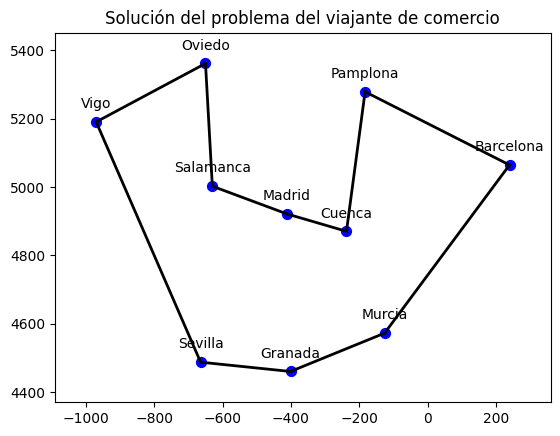

In [13]:
def VisualizaSolucion(x,ciudades,coord_car):

    # Crea una figura y un eje para el gráfico
    fig, ax = plt.subplots()

    # Establece los límites del gráfico
    minX = min(x for x, _ in coord_car)
    maxX = max(x for x, _ in coord_car)
    incX = (maxX-minX)/10
    minY = min(y for _,y in coord_car)
    maxY = max(y for _,y in coord_car)
    incY = (maxY-minY)/10
    ax.set_xlim(minX-incX, maxX+incX)
    ax.set_ylim(minY-incY, maxY+incY)

    # Añade un título y muestra el gráfico
    ax.set_title("Solución del problema del viajante de comercio")
    
    # Dibuja las rutas con líneas
    M = coord_car.shape[0]
    for i in range(M):            
        ciudad_i = x[i]
        ciudad_j = x[i+1]
        x_coord = [coord_car[ciudad_i][0], coord_car[ciudad_j][0]]
        y_coord = [coord_car[ciudad_i][1], coord_car[ciudad_j][1]]
        ax.plot(x_coord, y_coord, 'k-', linewidth=2)            

    # Dibuja las ciudades como puntos en el gráfico
    ax.scatter(coord_car[:, 0], coord_car[:, 1], c='b', marker='o', s=50)            

    # Agregar etiquetas a cada ciudad
    for i, txt in enumerate(ciudades):
        ax.annotate(txt, (coord_car[i][0], coord_car[i][1]), textcoords="offset points", xytext=(0,10), ha='center')
    
    # Actualiza el gráfico
    plt.draw()

print("Mejor solución encontrada:", best_solution)
print("Mejor solución encontrada: ", end='')
for i in best_solution:
    print(ciudades[i]," ", end='')
print()
print("Coste:", best_fitness)
VisualizaSolucion(best_solution,ciudades,coord_car)

### Visualización de la evolución del algoritmo

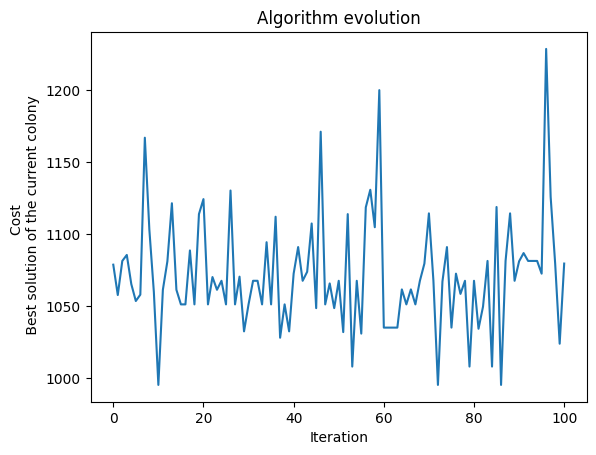

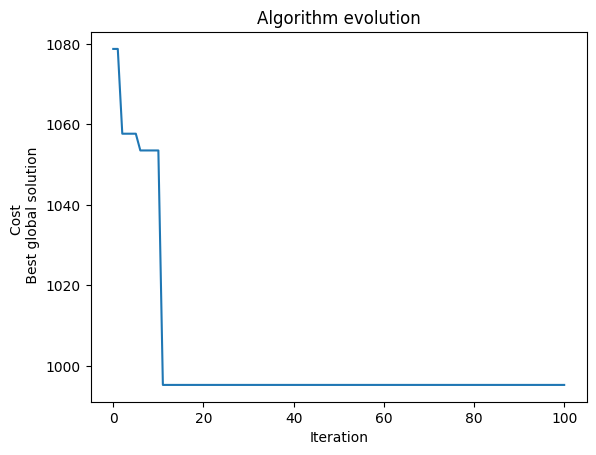

In [14]:
def VisualizaEvolucion(best_outputs,ylabel):
    fig, ax = plt.subplots()
    ax.set_title("Algorithm evolution")
    plt.plot(best_outputs)
    plt.xlabel("Iteration")
    plt.ylabel(ylabel)
    plt.show()
    
VisualizaEvolucion(best_outputs,"Cost \n Best solution of the current colony")
VisualizaEvolucion(best_outputs_global,"Cost \n Best global solution")